In [ ]:
import geopandas as gpd
import pandas as pd

# Cargar el shapefile de puntos (estaciones)
gdf = gpd.read_file('area_de_estudio/shape/Estaciones_IDEAM/CNE_IDEAM.shp')

# Cargar el Excel con los nombres y datos de las estaciones
df_excel = pd.read_excel('validacion/analisis-asociacion-estaciones.xlsx')

# Filtrar el GeoDataFrame solo a las estaciones presentes en el Excel
gdf_filtrado = gdf[gdf['nombre'].isin(df_excel['Estacion'])].copy()

# Unir los datos del Excel al GeoDataFrame filtrado usando el nombre de la estación
gdf_final = gdf_filtrado.merge(df_excel, left_on='nombre', right_on='Estacion', how='left')

# Ahora gdf_final contiene la geometría y los datos del Excel ("Correlacion", "R2", "p-value")

In [2]:
cuenca_orinoco = gpd.read_file('area_de_estudio/shape/cuenca_orinoquia/cuenca_orinoquia.shp')

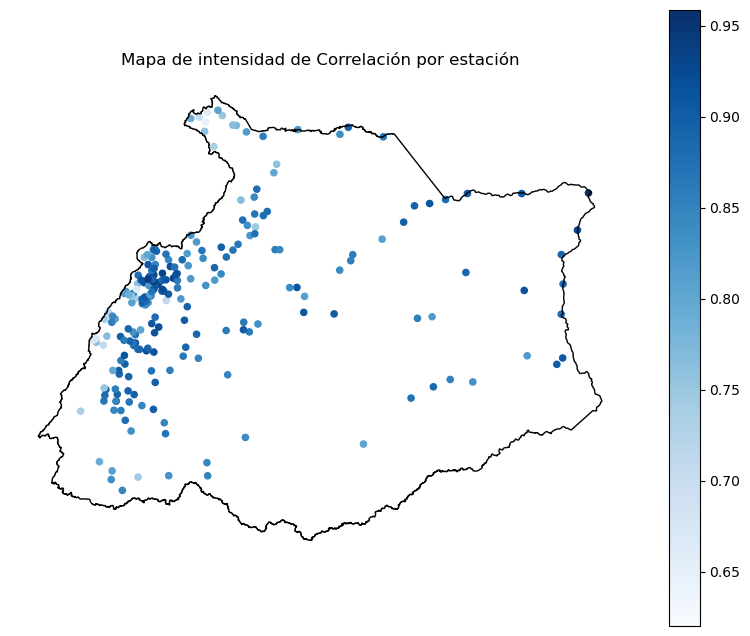

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
cuenca_orinoco.boundary.plot(ax=ax, linewidth=1, color='black', label='Cuenca Orinoco')
gdf_final.plot(column='Correlacion', cmap='Blues', legend=True, ax=ax, markersize=20)
ax.set_title('Mapa de intensidad de Correlación por estación')
ax.set_axis_off()
plt.show()

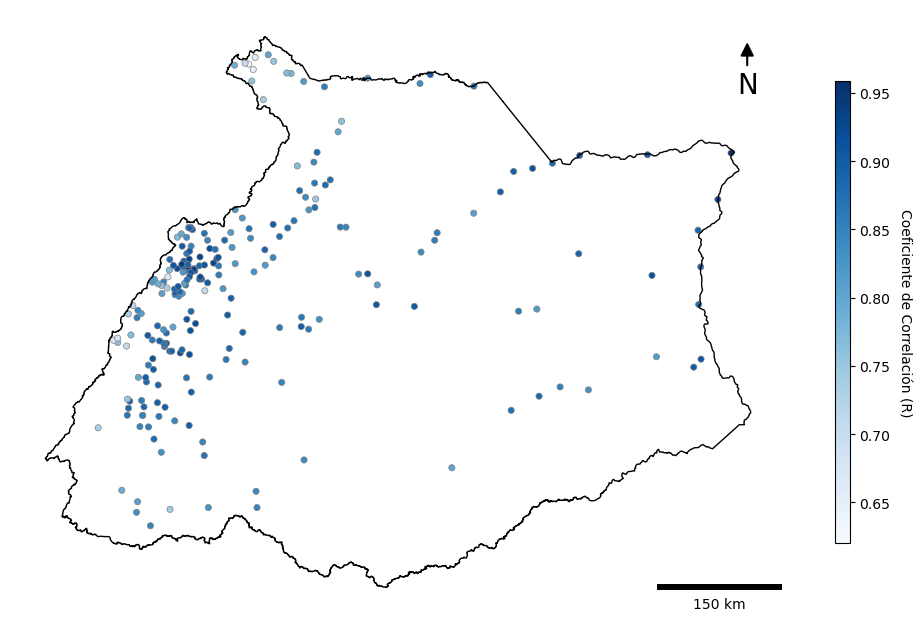


¡Mapa final generado y guardado como 'mapa_correlacion_final_ajustado.png' y .pdf!


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

# --- Carga de datos del usuario ---
# Cargar los archivos shapefile y Excel desde las rutas proporcionadas.
try:
    gdf_estaciones = gpd.read_file('area_de_estudio/shape/Estaciones_IDEAM/CNE_IDEAM.shp')
    df_excel = pd.read_excel('validacion/analisis-asociacion-estaciones.xlsx')
    cuenca_orinoco = gpd.read_file('area_de_estudio/shape/cuenca_orinoquia/cuenca_orinoquia.shp')
except FileNotFoundError as e:
    print(f"Error: No se pudo encontrar el archivo: {e.filename}")
    print("Por favor, asegúrate de que las rutas a tus archivos son correctas y vuelve a ejecutar el script.")
    # Salir si los archivos no se encuentran, para evitar más errores.
    exit()


# --- Procesamiento y unión de datos ---
# Filtrar el GeoDataFrame de estaciones para que coincida con las del Excel.
gdf_filtrado = gdf_estaciones[gdf_estaciones['nombre'].isin(df_excel['Estacion'])].copy()

# Unir los datos del Excel al GeoDataFrame usando el nombre de la estación como clave.
gdf_final = gdf_filtrado.merge(df_excel, left_on='nombre', right_on='Estacion', how='left')


# --- Verificación y Reproyección de CRS ---
# Es CRUCIAL que los datos estén en un CRS proyectado (en metros) para que la escala sea correcta.
# EPSG:32618 es WGS 84 / UTM zone 18N, adecuado para esta región de Colombia.
target_crs = "EPSG:32618"

if cuenca_orinoco.crs != target_crs:
    cuenca_orinoco = cuenca_orinoco.to_crs(target_crs)

if gdf_final.crs != target_crs:
    gdf_final = gdf_final.to_crs(target_crs)


# --- Funciones auxiliares para el mapa ---
def add_north_arrow(ax, location="upper right", size=0.05, lw=1.5, **kwargs):
    """
    Agrega una flecha de norte simple al eje del mapa.
    """
    x, y = 0, 0
    if location == 'upper right':
        x, y = 0.95, 0.95
    elif location == 'upper left':
        x, y = 0.05, 0.95

    arrow_props = dict(facecolor='black', edgecolor='black', lw=lw, arrowstyle='-|>')
    ax.annotate('N', xy=(x, y), xytext=(x, y - size*1.5),
                arrowprops=arrow_props,
                ha='center', va='center', fontsize=20,
                xycoords=ax.transAxes, textcoords=ax.transAxes)


# --- Creación del mapa ---
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# 1. Graficar el límite de la cuenca.
cuenca_orinoco.boundary.plot(ax=ax, linewidth=1, color='black')

# 2. Graficar los puntos de las estaciones.
# Se quita el 'label' de legend_kwds para ponerlo manualmente con más control.
gdf_final.plot(column='Correlacion',
               cmap='Blues',
               legend=True,
               ax=ax,
               markersize=20,
               edgecolor='gray',
               linewidth=0.5,
               legend_kwds={
                   'orientation': "vertical",
                   'shrink': 0.6,
                   'aspect': 30
               })

# --- AJUSTE DE LA LEYENDA ---
# Se obtiene el eje de la barra de color (la leyenda) para modificarlo.
# fig.axes[1] generalmente corresponde a la barra de color recién creada.
cbar_ax = fig.axes[1]
cbar_ax.set_ylabel(
    "Coeficiente de Correlación (R)",
    rotation=270,  # Rota el texto para que quede vertical.
    labelpad=15,   # Añade un espacio entre el texto y la barra.
    fontsize=10
)

# 3. Agregar la escala gráfica en kilómetros.
scalebar = ScaleBar(
    dx=1, # 1 unidad del mapa = 1 metro (porque el CRS está en metros).
    units="m",
    fixed_units="km", # Mostrar la escala en kilómetros.
    length_fraction=0.2,
    location='lower right',
    frameon=False,
    color='black',
    font_properties={'size': 10}
)
ax.add_artist(scalebar)

# 4. Agregar la flecha de norte.
add_north_arrow(ax, location='upper right')

# 5. Quitar los ejes para un look de mapa limpio.
ax.set_axis_off()

# 6. Ajustar el layout para evitar que los elementos se superpongan.
plt.tight_layout()

# 7. Guardar la figura en alta calidad.
plt.savefig("figuras/mapa_correlacion.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

# Finalmente, mostrar el gráfico en pantalla.
plt.show()

print("\n¡Mapa final generado y guardado como 'mapa_correlacion_final_ajustado.png' y .pdf!")


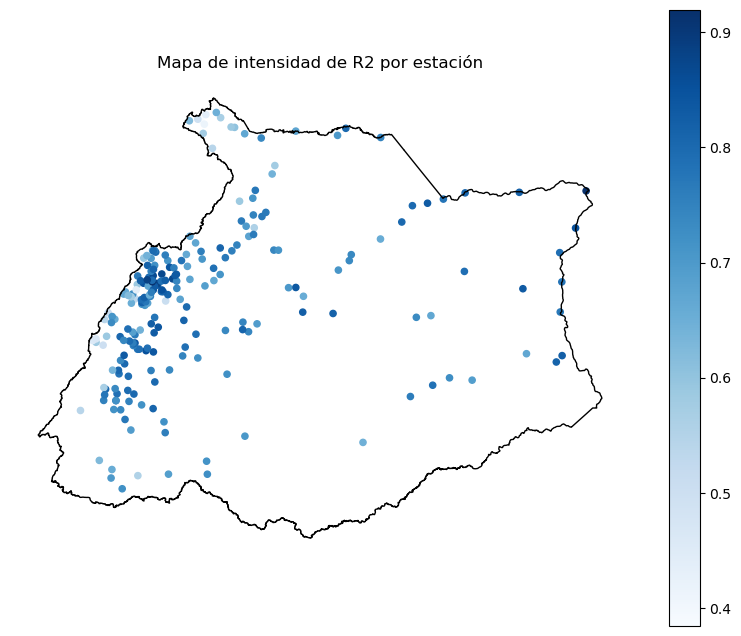

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
cuenca_orinoco.boundary.plot(ax=ax, linewidth=1, color='black', label='Cuenca Orinoco')
gdf_final.plot(column='R2', cmap='Blues', legend=True, ax=ax, markersize=20)
ax.set_title('Mapa de intensidad de R2 por estación')
ax.set_axis_off()
plt.show()

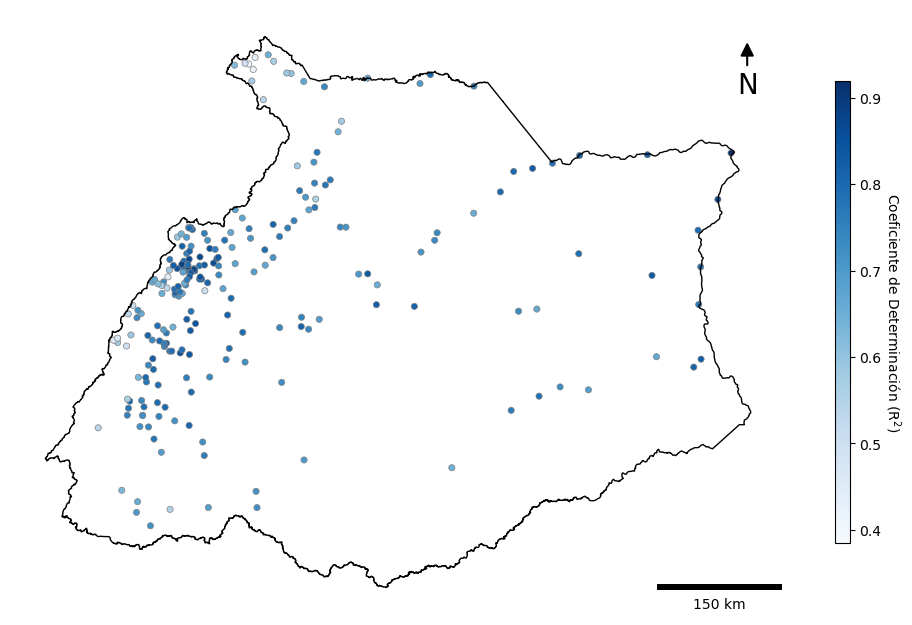


¡Mapa final generado y guardado como 'mapa_r2.png' y .pdf!


In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

# --- Carga de datos del usuario ---
# Cargar los archivos shapefile y Excel desde las rutas proporcionadas.
try:
    gdf_estaciones = gpd.read_file('area_de_estudio/shape/Estaciones_IDEAM/CNE_IDEAM.shp')
    df_excel = pd.read_excel('validacion/analisis-asociacion-estaciones.xlsx')
    cuenca_orinoco = gpd.read_file('area_de_estudio/shape/cuenca_orinoquia/cuenca_orinoquia.shp')
except FileNotFoundError as e:
    print(f"Error: No se pudo encontrar el archivo: {e.filename}")
    print("Por favor, asegúrate de que las rutas a tus archivos son correctas y vuelve a ejecutar el script.")
    # Salir si los archivos no se encuentran, para evitar más errores.
    exit()


# --- Procesamiento y unión de datos ---
# Filtrar el GeoDataFrame de estaciones para que coincida con las del Excel.
gdf_filtrado = gdf_estaciones[gdf_estaciones['nombre'].isin(df_excel['Estacion'])].copy()

# Unir los datos del Excel al GeoDataFrame usando el nombre de la estación como clave.
gdf_final = gdf_filtrado.merge(df_excel, left_on='nombre', right_on='Estacion', how='left')


# --- Verificación y Reproyección de CRS ---
# Es CRUCIAL que los datos estén en un CRS proyectado (en metros) para que la escala sea correcta.
# EPSG:32618 es WGS 84 / UTM zone 18N, adecuado para esta región de Colombia.
target_crs = "EPSG:32618"

if cuenca_orinoco.crs != target_crs:
    cuenca_orinoco = cuenca_orinoco.to_crs(target_crs)

if gdf_final.crs != target_crs:
    gdf_final = gdf_final.to_crs(target_crs)


# --- Funciones auxiliares para el mapa ---
def add_north_arrow(ax, location="upper right", size=0.05, lw=1.5, **kwargs):
    """
    Agrega una flecha de norte simple al eje del mapa.
    """
    x, y = 0, 0
    if location == 'upper right':
        x, y = 0.95, 0.95
    elif location == 'upper left':
        x, y = 0.05, 0.95

    arrow_props = dict(facecolor='black', edgecolor='black', lw=lw, arrowstyle='-|>')
    ax.annotate('N', xy=(x, y), xytext=(x, y - size*1.5),
                arrowprops=arrow_props,
                ha='center', va='center', fontsize=20,
                xycoords=ax.transAxes, textcoords=ax.transAxes)


# --- Creación del mapa ---
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# 1. Graficar el límite de la cuenca.
cuenca_orinoco.boundary.plot(ax=ax, linewidth=1, color='black')

# 2. Graficar los puntos de las estaciones.
# Se quita el 'label' de legend_kwds para ponerlo manualmente con más control.
gdf_final.plot(column='R2',
               cmap='Blues',
               legend=True,
               ax=ax,
               markersize=20,
               edgecolor='gray',
               linewidth=0.5,
               legend_kwds={
                   'orientation': "vertical",
                   'shrink': 0.6,
                   'aspect': 30
               })

# --- AJUSTE DE LA LEYENDA ---
# Se obtiene el eje de la barra de color (la leyenda) para modificarlo.
# fig.axes[1] generalmente corresponde a la barra de color recién creada.
cbar_ax = fig.axes[1]
cbar_ax.set_ylabel(
    "Coeficiente de Determinación (R$^2$)",
    rotation=270,  # Rota el texto para que quede vertical.
    labelpad=15,   # Añade un espacio entre el texto y la barra.
    fontsize=10
)

# 3. Agregar la escala gráfica en kilómetros.
scalebar = ScaleBar(
    dx=1, # 1 unidad del mapa = 1 metro (porque el CRS está en metros).
    units="m",
    fixed_units="km", # Mostrar la escala en kilómetros.
    length_fraction=0.2,
    location='lower right',
    frameon=False,
    color='black',
    font_properties={'size': 10}
)
ax.add_artist(scalebar)

# 4. Agregar la flecha de norte.
add_north_arrow(ax, location='upper right')

# 5. Quitar los ejes para un look de mapa limpio.
ax.set_axis_off()

# 6. Ajustar el layout para evitar que los elementos se superpongan.
plt.tight_layout()

# 7. Guardar la figura en alta calidad.
plt.savefig("figuras/mapa_r2.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

# Finalmente, mostrar el gráfico en pantalla.
plt.show()

print("\n¡Mapa final generado y guardado como 'mapa_r2.png' y .pdf!")